# Problem Statement
Traditional housing price models rely solely on tabular data (e.g., square footage, number of bedrooms, zip code). However, these models ignore a critical factor in a home's value: aesthetic appeal and condition. A house with "3 bedrooms" might be a renovated modern masterpiece or a fixer-upper. By ignoring visual data, models lose significant predictive power, leading to higher error rates in appraisals.

#Project Objective
The goal is to build a Multimodal Deep Learning Model that extracts visual features from house exterior/interior images using a Convolutional Neural Network (CNN) and concatenates them with structured metadata (tabular features). We will then pass this combined feature vector through a regression head to predict the final sale price, aiming to minimize $MAE$ (Mean Absolute Error) and $RMSE$ (Root Mean Squared Error). Finally, we will deploy the model via a Gradio UI for real-time predictions.

## Environment Setup

In [ ]:
!pip install tensorflow numpy pandas matplotlib scikit-learn gradio pillow

## Import Libraries

In [19]:
# Standard Data Handling
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Image Processing
import PIL
from PIL import Image

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, concatenate

# UI Framework
import gradio as gr

print("Environment setup complete. Libraries imported successfully!")

Environment setup complete. Libraries imported successfully!


## Data Loading

In [9]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Navigate to your zip file location (adjust the path)
%cd /content/drive/MyDrive/

# 3. Unzip the folder to Colab's content directory
!unzip -q "/content/drive/MyDrive/archive (1).zip" -d "/content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
replace /content/kaggle_room_street_data/house_data/bath_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/kaggle_room_street_data/house_data/bath_1001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/kaggle_room_street_data/house_data/bath_1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/kaggle_room_street_data/house_data/bath_1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n


In [10]:
import os

# Let's find the actual sub-folders
base_search = "/content/kaggle_room_street_data"

# This list comprehension finds where 'room_data' actually lives
found_room_paths = [root for root, dirs, files in os.walk(base_search) if 'room_data' in dirs]

if found_room_paths:
    room_dir = os.path.join(found_room_paths[0], "room_data")
    street_dir = os.path.join(found_room_paths[0], "street_data")
    print(f"✅ Found them! \nRoom Path: {room_dir}\nStreet Path: {street_dir}")
    print(f"Room images: {len(os.listdir(room_dir))} | Street images: {len(os.listdir(street_dir))}")
else:
    print("❌ Still can't find room_data. Let's list everything in that folder:")
    !ls -R /content/kaggle_room_street_data

Streaming output truncated to the last 5000 lines.
portland_BdIdx_11744_BdType_house.jpg
portland_BdIdx_11748_BdType_house.jpg
portland_BdIdx_11775_BdType_house.jpg
portland_BdIdx_11792_BdType_house.jpg
portland_BdIdx_11803_BdType_house.jpg
portland_BdIdx_11805_BdType_house.jpg
portland_BdIdx_11806_BdType_house.jpg
portland_BdIdx_11811_BdType_house.jpg
portland_BdIdx_11814_BdType_house.jpg
portland_BdIdx_11821_BdType_house.jpg
portland_BdIdx_11822_BdType_house.jpg
portland_BdIdx_11828_BdType_house.jpg
portland_BdIdx_11834_BdType_house.jpg
portland_BdIdx_11837_BdType_house.jpg
portland_BdIdx_11848_BdType_house.jpg
portland_BdIdx_11888_BdType_apartments.jpg
portland_BdIdx_119104_BdType_commercial.jpg
portland_BdIdx_11932_BdType_house.jpg
portland_BdIdx_1218_BdType_office.jpg
portland_BdIdx_12351_BdType_commercial.jpg
portland_BdIdx_1242_BdType_office.jpg
portland_BdIdx_12627_BdType_apartments.jpg
portland_BdIdx_12631_BdType_apartments.jpg
portland_BdIdx_12635_BdType_retail.jpg
portland_B

In [12]:
import os
import pandas as pd

def load_final_data():
    # 1. Load the Tabular Data from the web source
    csv_url = "https://raw.githubusercontent.com/emanhamed/Houses-dataset/master/Houses%20Dataset/HousesInfo.txt"
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

    print("Loading tabular data...")
    try:
        df = pd.read_csv(csv_url, sep=" ", header=None, names=cols)
        print(f"✅ Tabular data loaded! Shape: {df.shape}")
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return None, None

    # 2. Set the Image Directory
    # Based on your unzip output, the images are in 'house_data' inside 'kaggle_room_street_data'
    img_dir = "/content/kaggle_room_street_data/house_data"

    # 3. Path Validation
    if os.path.exists(img_dir):
        file_count = len(os.listdir(img_dir))
        print(f"✅ Image directory found: {img_dir}")
        print(f"✅ Total image files found: {file_count}")

        # Look at a few sample filenames to ensure the 'bath_ID' format is correct
        samples = os.listdir(img_dir)[:5]
        print(f"Sample filenames: {samples}")
    else:
        print(f"❌ Image directory NOT found at: {img_dir}")
        print("Checking what is actually inside /content/kaggle_room_street_data...")
        !ls /content/kaggle_room_street_data

    return df, img_dir

# Execute the loading
df, img_folder = load_final_data()

# Show first few rows of the table
if df is not None:
    display(df.head())

Loading tabular data...
✅ Tabular data loaded! Shape: (535, 5)
✅ Image directory found: /content/kaggle_room_street_data/house_data
✅ Total image files found: 5249
Sample filenames: ['living_460.jpg', 'din_459.jpg', 'din_354.jpg', 'kitchen_296.jpg', 'living_206.jpg']


,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


# Preprocessing & Montage Creation
We need to transform the raw data into something the machine can learn from
## Images:
We will create a "4-pane montage" for each house. This combines the Bathroom, Bedroom, Kitchen, and Frontal view into a single $64 \times 64$ image. This allows the CNN to see the whole house "at once."
## Tabular:
 We will normalize the area and rooms, and we must perform One-Hot Encoding on the Zipcodes.

In [15]:
# Check the first 10 files in the image folder
sample_files = os.listdir(img_folder)[:10]
print("Actual filenames in folder:", sample_files)

Actual filenames in folder: ['living_460.jpg', 'din_459.jpg', 'din_354.jpg', 'kitchen_296.jpg', 'living_206.jpg', 'bed_171.jpg', 'bed_1244.jpg', 'bed_480.jpg', 'living_665.jpg', 'din_1052.jpg']


In [16]:
def preprocess_multimodal_data_final(df, img_folder):
    images = []
    tabular = []
    labels = []

    print(f"Checking {len(df)} rows against images in {img_folder}...")

    for i in range(len(df)):
        # House ID is usually the index
        # Some datasets start at 0, others at 1. Let's check both.
        hid = i

        # We search for the 4 prefixes found in your folder
        p_kit  = os.path.join(img_folder, f"kitchen_{hid}.jpg")
        p_bed  = os.path.join(img_folder, f"bed_{hid}.jpg")
        p_liv  = os.path.join(img_folder, f"living_{hid}.jpg")
        p_din  = os.path.join(img_folder, f"din_{hid}.jpg")

        # If not found at 'i', try 'i+1'
        if not os.path.exists(p_kit):
            hid = i + 1
            p_kit  = os.path.join(img_folder, f"kitchen_{hid}.jpg")
            p_bed  = os.path.join(img_folder, f"bed_{hid}.jpg")
            p_liv  = os.path.join(img_folder, f"living_{hid}.jpg")
            p_din  = os.path.join(img_folder, f"din_{hid}.jpg")

        # Check if all 4 categories exist for this specific ID
        if all(os.path.exists(p) for p in [p_kit, p_bed, p_liv, p_din]):
            imgs = []
            for p in [p_kit, p_bed, p_liv, p_din]:
                img = cv2.imread(p)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (32, 32))
                imgs.append(img)

            # Create 64x64 montage
            top = np.hstack([imgs[0], imgs[1]]) # Kitchen | Bed
            bottom = np.hstack([imgs[2], imgs[3]]) # Living | Dining
            montage = np.vstack([top, bottom])

            images.append(montage / 255.0)
            tabular.append(df.iloc[i][["bedrooms", "bathrooms", "area"]].values)
            labels.append(df.iloc[i]["price"])

    return np.array(images), np.array(tabular), np.array(labels)

# 1. Execute the matching
X_img, X_tab_raw, y = preprocess_multimodal_data_final(df, img_folder)

# 2. Scaling (This will now work if y is not empty!)
if len(y) > 0:
    scaler = MinMaxScaler()
    X_tab = scaler.fit_transform(X_tab_raw)
    y_max = y.max()
    y_normalized = y / y_max

    # 3. Split the data
    split = train_test_split(X_img, X_tab, y_normalized, test_size=0.25, random_state=42)
    (trainX_img, testX_img, trainX_tab, testX_tab, trainY, testY) = split

    print(f"✅ Success! Found matches for {len(y)} houses.")
    print(f"Shapes: Images {X_img.shape}, Tabular {X_tab.shape}")
else:
    print("❌ Still no matches. Please double check if the IDs in filenames (like bed_171.jpg) match the CSV indices.")

Checking 535 rows against images in /content/kaggle_room_street_data/house_data...
✅ Success! Found matches for 257 houses.
Shapes: Images (257, 64, 64, 3), Tabular (257, 3)


# Building the Multimodal Neural Network

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

def create_mlp(dim):
    # Use Functional API for MLP to avoid "never been called" error
    inputs = Input(shape=(dim,))
    x = Dense(8, activation="relu")(inputs)
    x = Dense(4, activation="relu")(x)
    model = Model(inputs, x)
    return model

def create_cnn(width, height, depth):
    # CNN for image data branch
    inputs = Input(shape=(height, width, depth))

    x = Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)

    model = Model(inputs, x)
    return model

# 1. Initialize the two branches
# Using .shape[1] because we have 3 features (Bed, Bath, Area)
mlp = create_mlp(trainX_tab.shape[1])
cnn = create_cnn(64, 64, 3)

# 2. Combine the outputs (Fusion)
# Now both branches have defined .input and .output
combined_input = concatenate([mlp.output, cnn.output])

# 3. Final Regression Head
x = Dense(4, activation="relu")(combined_input)
x = Dense(1, activation="linear")(x)

# 4. Final Multimodal Model
# We pass the list of inputs and the final output x
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# 5. Compile
opt = Adam(learning_rate=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

print("✅ Multimodal Model compiled successfully with Functional API!")
model.summary()

✅ Multimodal Model compiled successfully with Functional API!


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │        448 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │         32 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4096)      │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │         36 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │     65,552 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │         84 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          5 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,293 (348.80 KB)

 Trainable params: 89,293 (348.80 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [23]:
print("Starting training...")
# Note: x is a list containing both tabular and image arrays
history = model.fit(
    x=[trainX_tab, trainX_img],
    y=trainY,
    validation_data=([testX_tab, testX_img], testY),
    epochs=50,
    batch_size=8
)

Starting training...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 103.6618 - val_loss: 67.2425
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 70.2804 - val_loss: 72.3078
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 58.2536 - val_loss: 74.2263
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 61.3069 - val_loss: 73.7795
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 64.3052 - val_loss: 72.5392
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 63.5679 - val_loss: 71.9405
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 61.7987 - val_loss: 73.3623
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 59.4847 - val_loss: 73.3522
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 65.1842 - val_loss: 72.1721
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 63.9532 - val_loss: 72.3625
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 64.2653 - val_loss: 72.7359
Epoch 12/50
24/24 ━

# Evaluate Training & Performance

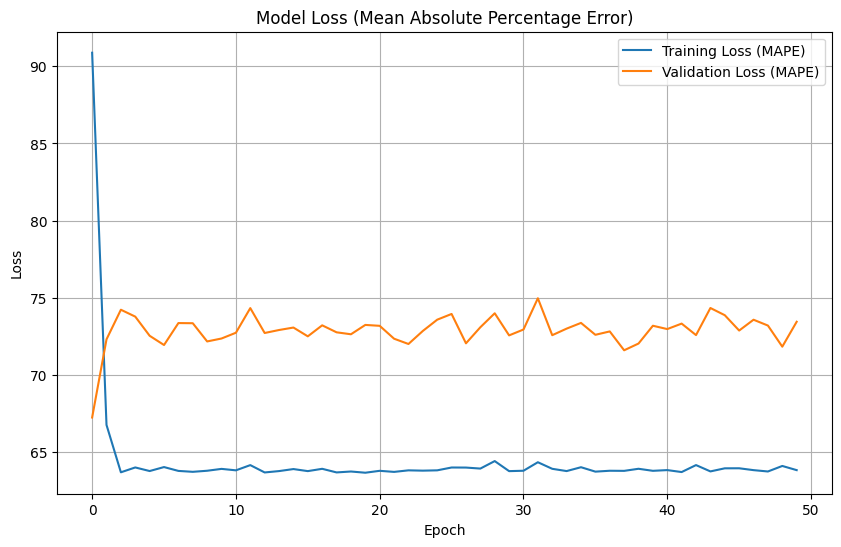

Evaluating on test data...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
--- Performance Report ---
Mean Price Error: $450,962.29
Mean Percentage Error (MAPE): 73.45%


In [24]:
import matplotlib.pyplot as plt

# 1. Plot the training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MAPE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAPE)')
plt.title('Model Loss (Mean Absolute Percentage Error)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 2. Make predictions and convert back to actual prices
print("Evaluating on test data...")
preds = model.predict([testX_tab, testX_img])

# Rescale prices back to original values
# We divide by y_max earlier, so we multiply now
final_preds = preds.flatten() * y_max
final_actual = testY * y_max

# 3. Calculate Mean Absolute Error in dollars
diff = final_preds - final_actual
percent_diff = (np.abs(diff) / final_actual) * 100
abs_percent_diff = np.abs(percent_diff)

mean_mape = np.mean(abs_percent_diff)
std_mape = np.std(abs_percent_diff)

print(f"--- Performance Report ---")
print(f"Mean Price Error: ${np.mean(np.abs(diff)):,.2f}")
print(f"Mean Percentage Error (MAPE): {mean_mape:.2f}%")

# Save the Model and Scale

In [25]:
import pickle

# Save the Keras model
model.save("house_price_model.keras")

# Save the MinMaxScaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the max price for denormalization
with open("y_max.txt", "w") as f:
    f.write(str(y_max))

print("✅ Model, Scaler, and Metadata saved successfully!")

✅ Model, Scaler, and Metadata saved successfully!


# The Gradio UI Deployment

In [ ]:

import gradio as gr
import numpy as np
import cv2
import pickle
import tensorflow as tf

# 1. Load the assets we saved
model = tf.keras.models.load_model("house_price_model.keras")
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("y_max.txt", "r") as f:
    y_max = float(f.read())

def predict_house_price(beds, baths, area, kit_img, bath_img, bed_img, liv_img):
    # --- Process Tabular Data ---
    # Convert inputs to the same scale used in training
    tab_input = np.array([[beds, baths, area]])
    tab_scaled = scaler.transform(tab_input)

    # --- Process Images (Create Montage) ---
    processed_imgs = []
    for img in [kit_img, bath_img, bed_img, liv_img]:
        if img is None:
            return "Please upload all 4 images."
        # Resize and normalize
        img_resized = cv2.resize(img, (32, 32))
        processed_imgs.append(img_resized / 255.0)

    # Stack into 64x64 montage
    top = np.hstack([processed_imgs[0], processed_imgs[1]])
    bottom = np.hstack([processed_imgs[2], processed_imgs[3]])
    montage = np.vstack([top, bottom])
    img_input = np.expand_dims(montage, axis=0) # Add batch dimension

    # --- Prediction ---
    prediction = model.predict([tab_scaled, img_input])[0][0]
    final_price = prediction * y_max

    return f"Predicted House Price: ${final_price:,.2f}"

# 2. Define the Gradio Interface
interface = gr.Interface(
    fn=predict_house_price,
    inputs=[
        gr.Number(label="Bedrooms"),
        gr.Number(label="Bathrooms"),
        gr.Number(label="Total Area (sq ft)"),
        gr.Image(label="Kitchen Image"),
        gr.Image(label="Bathroom Image"),
        gr.Image(label="Bedroom Image"),
        gr.Image(label="Living Room Image")
    ],
    outputs=gr.Textbox(label="Valuation Result"),
    title="🏠 Multimodal AI Real Estate Appraiser",
    description="Upload house stats and room images to get an AI-powered price estimate."
)

# 3. Launch!
interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4e96cad6887f858610.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
